In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

from IPython.display import HTML, display
import base64
from pathlib import Path

## Show slices of phase

In [41]:
def _load_vol(path):
    arr = np.load(path)
    return np.abs(arr) if np.iscomplexobj(arr) else arr

def _ifftshift(vol):
    a = np.fft.ifftshift(np.abs(vol), axes=(0, 1, 2))
    return a

def _get_slice(vol, view="axial", idx=None):
    X, Y, Z = vol.shape
    if view == "sagittal":      # slice along Z
        k = Z // 2 if idx is None else int(idx)
        k = np.clip(k, 0, Z-1)
        return vol[:, :, k]
    elif view == "coronal":  # slice along Y
        j = Y // 2 if idx is None else int(idx)
        j = np.clip(j, 0, Y-1)
        return vol[:, j, :]
    elif view == "axial": # slice along X
        i = X // 2 if idx is None else int(idx)
        i = np.clip(i, 0, X-1)
        return vol[i, :, :]
    else:
        raise ValueError("view must be 'axial' | 'coronal' | 'sagittal'")

def show_phase_all_views(
    phase=1,
    slice_index=None,                          # slice index per view (None = mid)
    cg_dir="cg_baseline_numpy_3d",
    nocue_dir="recon/inference_all_phases_1",
    cue_dir="infer_cued",
    cmap="gray",
    prct=(1.0, 99.5)                     # shared window per view across methods
):
    """
    Renders a 3x3 grid:
        rows = views [axial, coronal, sagittal]
        cols = methods [CG-SENSE, ZS-SSL (no cue), ZS-SSL (with cue)]
    """
    p = int(phase)
    cg_path   = os.path.join(cg_dir,   f"phase_{p:02d}_cg_sos.npy")
    nocue_path = os.path.join(nocue_dir, f"phase_{p:02d}_recon_sos.npy")
    cue_path   = os.path.join(cue_dir,   f"phase_{p:02d}_recon_img.npy")

    # Load volumes (X,Y,Z), magnitude if complex
    if not (os.path.isfile(cg_path) and os.path.isfile(nocue_path) and os.path.isfile(cue_path)):
        raise FileNotFoundError(
            f"Missing file(s). Expected:\n"
            f"  {cg_path}\n  {nocue_path}\n  {cue_path}"
        )
    vol_cg    = _load_vol(cg_path)
    vol_nocue = _ifftshift(_load_vol(nocue_path))
    vol_cue   = _ifftshift(_load_vol(cue_path))

    views = ["axial", "coronal", "sagittal"]
    methods = ["CG-SENSE", "ZS-SSL", "ZS-SSL (with temporal cue)"]
    vols = [vol_cg, vol_nocue, vol_cue]

    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    for r, view in enumerate(views):
        # collect slices for this view across the three methods
        slices = [_get_slice(v, view=view, idx=slice_index) for v in vols]
        stack = np.concatenate([s.ravel() for s in slices])
        vmin, vmax = np.percentile(stack, prct[0]), np.percentile(stack, prct[1])

        for c, (s, mname) in enumerate(zip(slices, methods)):
            ax = axes[r, c]
            if (view == 'sagittal'):
                im = ax.imshow(np.rot90(np.rot90(s)), cmap=cmap, vmin=vmin, vmax=vmax, origin="lower")
            else:
                im = ax.imshow(s, cmap=cmap, vmin=vmin, vmax=vmax, origin="lower")
            if r == 0:
                ax.set_title(mname, fontsize=11)
            if c == 0:
                ax.set_ylabel(view, fontsize=11)
            ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    plt.show()

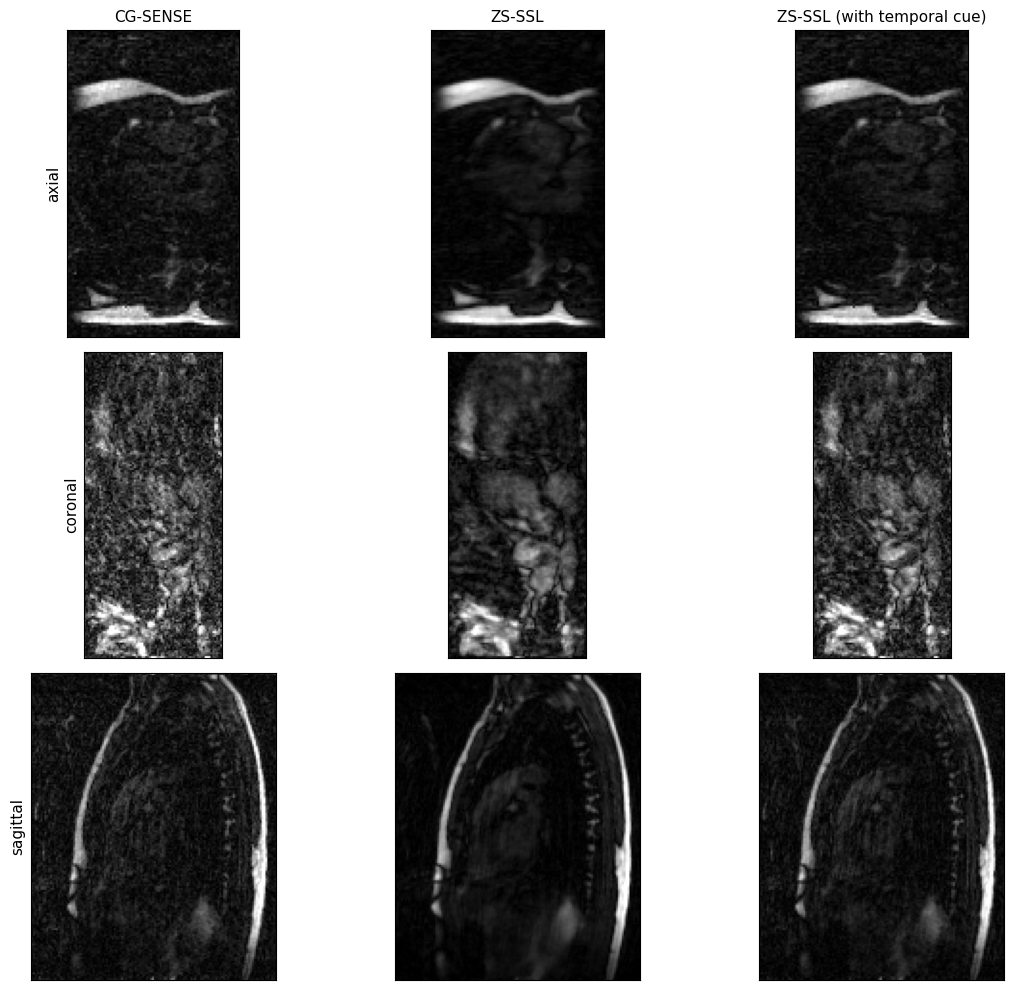

In [42]:
show_phase_all_views(phase=4)                # mid-slices of all views

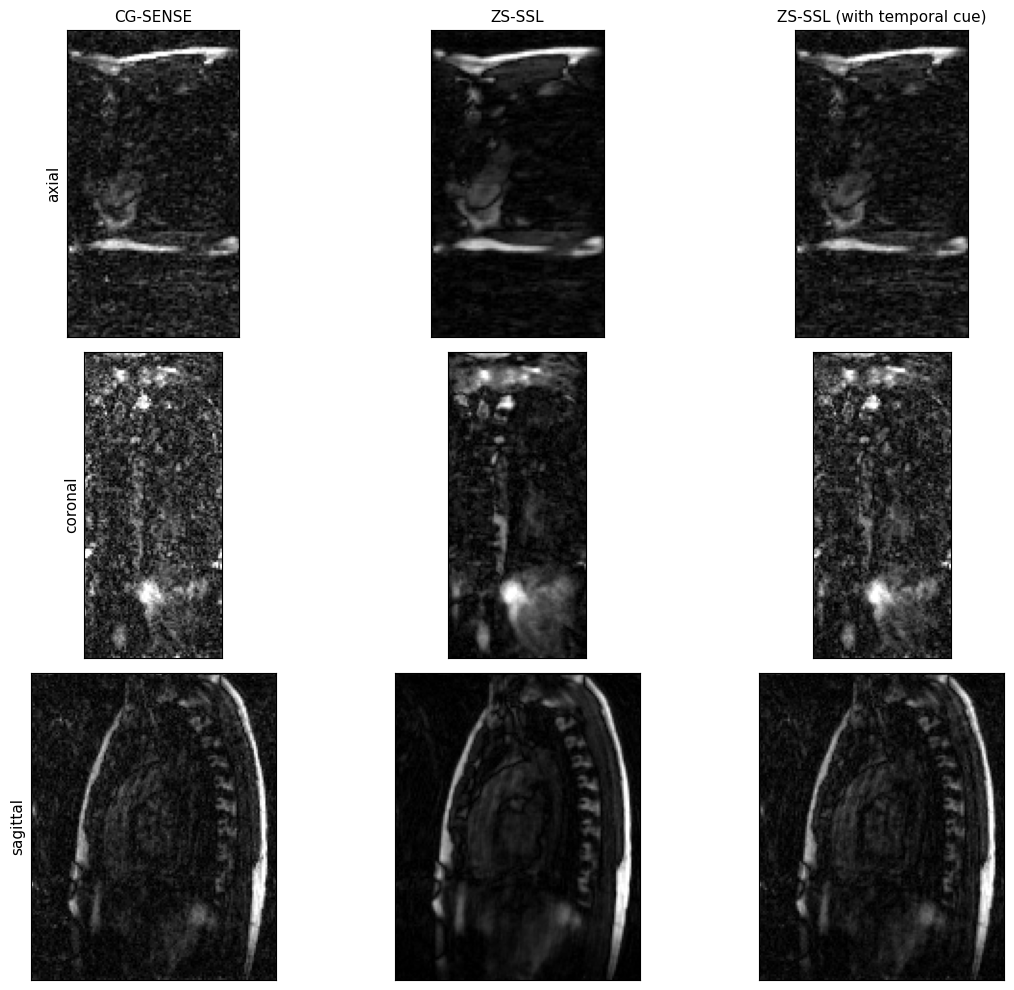

In [31]:
show_phase_all_views(phase=4, slice_index=40)

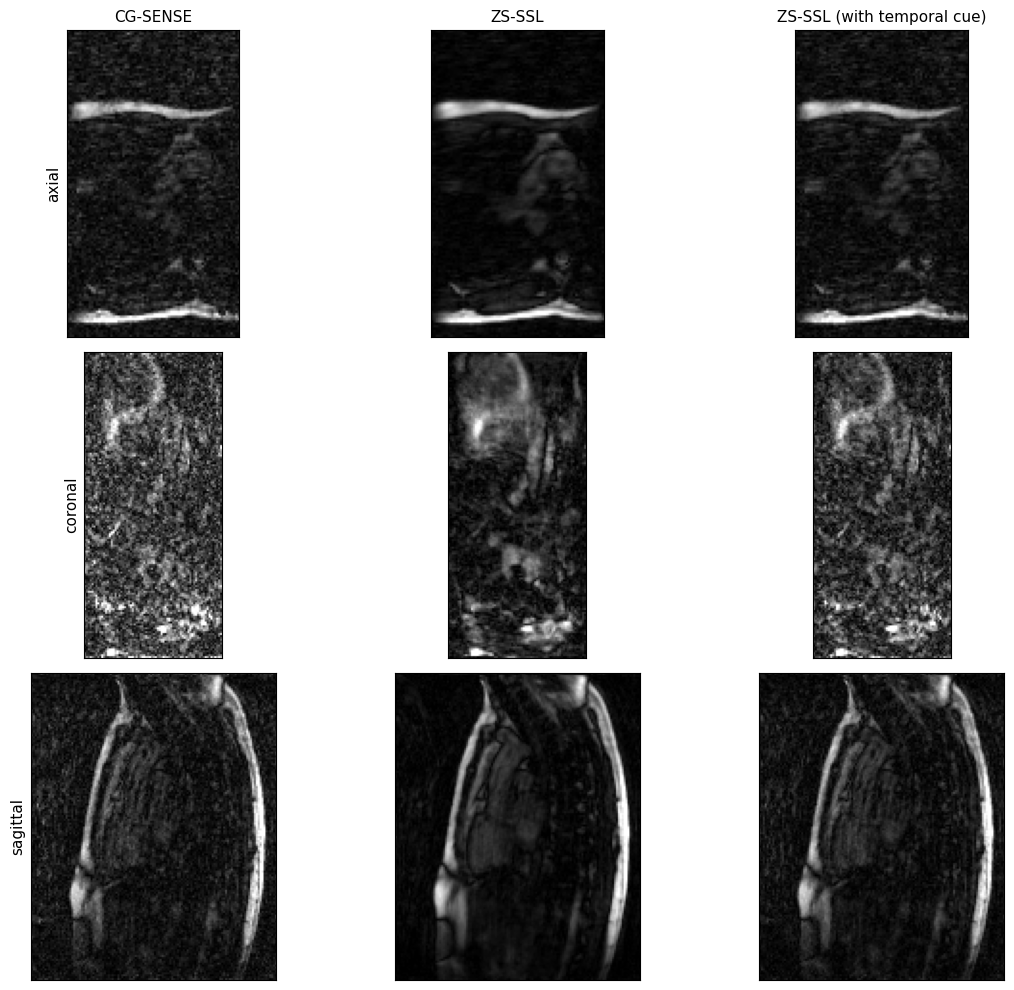

In [44]:
show_phase_all_views(phase=10, slice_index=50)

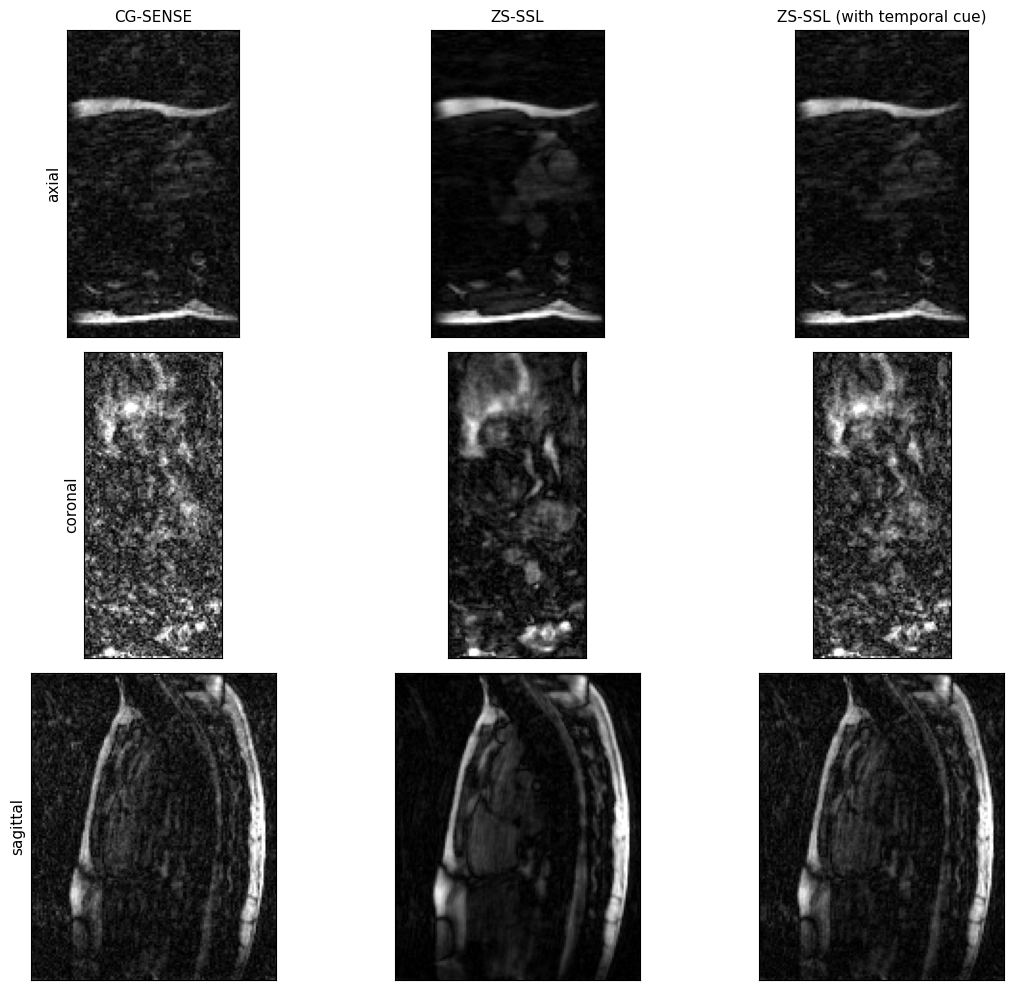

In [45]:
show_phase_all_views(phase=17, slice_index=52)

## Show GIFs of all slices of a phase

In [109]:
def _load_vol(path):
    arr = np.load(path)
    return np.abs(arr) if np.iscomplexobj(arr) else arr  # (X,Y,Z)

def _ifftshift(vol):
    a = np.fft.ifftshift(np.abs(vol), axes=(0, 1, 2))
    return a

def _to_uint8(x, vmin, vmax):
    x = np.clip((x - vmin) / max(vmax - vmin, 1e-9), 0, 1)
    return (x * 255.0).astype(np.uint8)

def _slice_sagittal(v, k):      # (X,Y,Z) -> (Z,Y)
    return v[:, :, k]

def _slice_coronal(v, j):    # (X,Y,Z) -> (X,Z) (we keep this orientation)
    return v[:, j, :]

def _slice_axial(v, i):   # (X,Y,Z) -> (X,Y) by transpose for consistent display
    return v[i, :, :]

def make_phase_gif_view(
    phase=1,
    view="axial",                     # 'axial' | 'coronal' | 'sagittal'
    cg_dir="cg_baseline_numpy_3d",
    nocue_dir="recon/inference_all_phases_1",
    cue_dir="infer_cued",
    out_gif=None,
    fps=8,
    prct=(1.0, 99.5),
):
    p = int(phase)
    cg_path    = os.path.join(cg_dir,    f"phase_{p:02d}_cg_sos.npy")
    nocue_path = os.path.join(nocue_dir, f"phase_{p:02d}_recon_sos.npy")
    cue_path   = os.path.join(cue_dir,   f"phase_{p:02d}_recon_img.npy")

    if not (os.path.isfile(cg_path) and os.path.isfile(nocue_path) and os.path.isfile(cue_path)):
        raise FileNotFoundError(
            f"Missing file(s). Expected:\n  {cg_path}\n  {nocue_path}\n  {cue_path}"
        )

    # Load volumes (X,Y,Z)
    vol_cg    = _load_vol(cg_path)
    vol_nocue = _ifftshift(_load_vol(nocue_path))
    vol_cue   = _ifftshift(_load_vol(cue_path))

    X, Y, Z = vol_cg.shape
    assert vol_nocue.shape == (X, Y, Z) and vol_cue.shape == (X, Y, Z), "Volume shapes must match"

    # Shared robust window across all three volumes
    stack = np.concatenate([vol_cg.ravel(), vol_nocue.ravel(), vol_cue.ravel()])
    vmin, vmax = np.percentile(stack, prct[0]), np.percentile(stack, prct[1])

    # Choose slicer and number of frames by view
    if view == "axial":
        slicer = lambda v, idx: _slice_axial(v, idx)
        T = X
    elif view == "coronal":
        slicer = lambda v, idx: _slice_coronal(v, idx)
        T = Y
    elif view == "sagittal":
        slicer = lambda v, idx: _slice_sagittal(v, idx)
        T = Z
    else:
        raise ValueError("view must be 'axial' | 'coronal' | 'sagittal'")

    frames = []
    for t in range(T):
        s_cg    = _to_uint8(slicer(vol_cg,    t), vmin, vmax)
        s_nocue = _to_uint8(slicer(vol_nocue, t), vmin, vmax)
        s_cue   = _to_uint8(slicer(vol_cue,   t), vmin, vmax)

        row = np.hstack([s_cg, s_nocue, s_cue])  # side-by-side columns
        frame_rgb = np.stack([row, row, row], axis=-1)  # grayscale -> RGB
        frames.append(frame_rgb)

    if out_gif is None:
        out_gif = os.path.join('results', f"phase_{p:02d}_{view}.gif")

    imageio.mimsave(out_gif, frames, duration=1.0 / fps, loop=0)
    print(f"Saved GIF → {out_gif}  | phase={p:02d}  | view={view}  | frames={len(frames)}  | fps={fps}")


In [110]:
def show_gif(path, width=800):
    """
    Display a GIF inline (embedded) in Jupyter.
    Args:
        path  : str or Path to the .gif file
        width : pixel width of the displayed GIF
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"GIF not found: {path}")
    b64 = base64.b64encode(path.read_bytes()).decode('ascii')
    html = f'<img src="data:image/gif;base64,{b64}" width="{int(width)}">'
    display(HTML(html))

In [111]:
make_phase_gif_view(phase=4, view="axial")
make_phase_gif_view(phase=4, view="coronal")
make_phase_gif_view(phase=4, view="sagittal")

Saved GIF → results/phase_04_axial.gif  | phase=04  | view=axial  | frames=160  | fps=8
Saved GIF → results/phase_04_coronal.gif  | phase=04  | view=coronal  | frames=128  | fps=8
Saved GIF → results/phase_04_sagittal.gif  | phase=04  | view=sagittal  | frames=72  | fps=8


In [112]:
make_phase_gif_view(phase=10, view="axial")
make_phase_gif_view(phase=10, view="coronal")
make_phase_gif_view(phase=10, view="sagittal")

Saved GIF → results/phase_10_axial.gif  | phase=10  | view=axial  | frames=160  | fps=8
Saved GIF → results/phase_10_coronal.gif  | phase=10  | view=coronal  | frames=128  | fps=8
Saved GIF → results/phase_10_sagittal.gif  | phase=10  | view=sagittal  | frames=72  | fps=8


## Show GIFs of a slice from all phases

In [ ]:
def _ifftshift(vol):
    a = np.fft.ifftshift(np.abs(vol), axes=(0, 1, 2))
    return a

def _load_vol(path):
    arr = np.load(path)
    return np.abs(arr) if np.iscomplexobj(arr) else arr  # (X,Y,Z)

def _slice_from_view(vol, view="axial", idx=None):
    """vol: (X,Y,Z) -> return 2D slice for view; if idx is None, returns list of all slices."""
    X, Y, Z = vol.shape
    if view == "axial":
        if idx is None:
            return [vol[i, :, :]           for i in range(X)]
        k = int(np.clip(idx, 0, X-1))
        return vol[i, :, :] 
    elif view == "coronal":
        if idx is None:
            return [vol[:, j, :]         for j in range(Y)]  # (Z,X)->(X,Z)-like
        j = int(np.clip(idx, 0, Y-1))
        return vol[:, j, :]
    elif view == "sagittal":
        if idx is None:
            return [vol[:, :, k]         for k in range(Z)]  # (Z,Y)->(Y,Z)-like
        i = int(np.clip(idx, 0, Z-1))
        return vol[:, :, k] 
    else:
        raise ValueError("view must be 'axial' | 'coronal' | 'sagittal'")

def _to_uint8(img, vmin, vmax):
    x = np.clip((img - vmin) / max(vmax - vmin, 1e-9), 0, 1)
    return (x * 255.0).astype(np.uint8)

def make_phase_gif_side_by_side(
    phase,
    view="axial",
    slice_index=None,              # None => animate all slices; int => single-slice GIF
    cg_dir="cg_baseline_numpy_3d",
    nocue_dir="recon/inference_all_phases_1",
    cue_dir="infer_cued",
    cg_name="phase_{:02d}_cg_sos.npy",
    nocue_name="phase_{:02d}_recon_sos.npy",
    cue_name="phase_{:02d}_recon_img.npy",
    out_gif="phase_side_by_side.gif",
    fps=6,
    prct=(1.0, 99.5)
):
    # ---- load volumes (X,Y,Z), float ----
    cg_path    = os.path.join(cg_dir,    cg_name.format(phase))
    nocue_path = os.path.join(nocue_dir, nocue_name.format(phase))
    cue_path   = os.path.join(cue_dir,   cue_name.format(phase))
    if not (os.path.exists(cg_path) and os.path.exists(nocue_path) and os.path.exists(cue_path)):
        missing = [p for p in [cg_path, nocue_path, cue_path] if not os.path.exists(p)]
        raise FileNotFoundError(f"Missing file(s): {missing}")

    cg    = _load_vol(cg_path)
    nocue = _ifftshift(_load_vol(nocue_path))
    cue   = _ifftshift(_load_vol(cue_path))

    # ---- slice extraction ----
    cg_s    = _slice_from_view(cg,    view=view, idx=slice_index)
    nocue_s = _slice_from_view(nocue, view=view, idx=slice_index)
    cue_s   = _slice_from_view(cue,   view=view, idx=slice_index)

    # Ensure lists for unified handling
    if isinstance(cg_s, np.ndarray):
        cg_s, nocue_s, cue_s = [cg_s], [nocue_s], [cue_s]

    # ---- global intensity window across all frames and methods ----
    stack_vals = np.concatenate([s.ravel() for s in (cg_s + nocue_s + cue_s)])
    vmin, vmax = np.percentile(stack_vals, prct[0]), np.percentile(stack_vals, prct[1])

    # ---- build frames (CG | NoCue | Cue) ----
    frames = []
    for s_cg, s_nc, s_cu in zip(cg_s, nocue_s, cue_s):
        L = _to_uint8(s_cg, vmin, vmax)
        M = _to_uint8(s_nc, vmin, vmax)
        R = _to_uint8(s_cu, vmin, vmax)
        # make 3-channel and concatenate horizontally
        L3 = np.stack([L, L, L], axis=-1)
        M3 = np.stack([M, M, M], axis=-1)
        R3 = np.stack([R, R, R], axis=-1)
        frame = np.concatenate([L3, M3, R3], axis=1)  # (H, W*3, 3)
        frames.append(frame)

    imageio.mimsave(out_gif, frames, duration=1.0 / fps, loop=0)
    nframes = len(frames)
    what = f"slice={slice_index}" if slice_index is not None else "all slices"
    print(f"Saved → {out_gif}  | phase={phase:02d} | view={view} | frames={nframes} ({what}) | fps={fps}")

In [113]:
# 1) Phase 4, axial, animate all axial slices
make_phase_gif_side_by_side(
    phase=4, view="axial", slice_index=None,
    out_gif="results/phase01_axial_sbs.gif"
)

# 2) Phase 17, sagittal, single mid-slice
make_phase_gif_side_by_side(
    phase=17, view="sagittal", slice_index=None,   # set to an int for a single-slice GIF
    out_gif="results/phase01_sagittal_sbs.gif"
)

# 3) Phase 1, coronal, specific slice 60 only
make_phase_gif_side_by_side(
    phase=1, view="coronal", slice_index=None,
    out_gif="results/phase01_coronal_sbs.gif"
)

Saved → results/phase01_axial_sbs.gif  | phase=04 | view=axial | frames=160 (all slices) | fps=6
Saved → results/phase01_sagittal_sbs.gif  | phase=17 | view=sagittal | frames=72 (all slices) | fps=6
Saved → results/phase01_coronal_sbs.gif  | phase=01 | view=coronal | frames=128 (all slices) | fps=6


In [114]:
# 1) Phase 4, axial, animate all axial slices
make_phase_gif_side_by_side(
    phase=4, view="axial", slice_index=None,
    out_gif="phase10_axial_sbs.gif"
)

# 2) Phase 17, sagittal, single mid-slice
make_phase_gif_side_by_side(
    phase=17, view="sagittal", slice_index=None,   # set to an int for a single-slice GIF
    out_gif="phase10_sagittal_sbs.gif"
)

# 3) Phase 1, coronal, specific slice 60 only
make_phase_gif_side_by_side(
    phase=1, view="coronal", slice_index=None,
    out_gif="phase10_coronal_sbs.gif"
)

Saved → phase10_axial_sbs.gif  | phase=04 | view=axial | frames=160 (all slices) | fps=6
Saved → phase10_sagittal_sbs.gif  | phase=17 | view=sagittal | frames=72 (all slices) | fps=6
Saved → phase10_coronal_sbs.gif  | phase=01 | view=coronal | frames=128 (all slices) | fps=6


In [115]:
# 1) Phase 4, axial, animate all axial slices
make_phase_gif_side_by_side(
    phase=4, view="axial", slice_index=None,
    out_gif="phase17_axial_sbs.gif"
)

# 2) Phase 17, sagittal, single mid-slice
make_phase_gif_side_by_side(
    phase=17, view="sagittal", slice_index=None,   # set to an int for a single-slice GIF
    out_gif="phase17_sagittal_sbs.gif"
)

# 3) Phase 1, coronal, single mid-slice
make_phase_gif_side_by_side(
    phase=1, view="coronal", slice_index=None,
    out_gif="phase17_coronal_sbs.gif"
)

Saved → phase17_axial_sbs.gif  | phase=04 | view=axial | frames=160 (all slices) | fps=6
Saved → phase17_sagittal_sbs.gif  | phase=17 | view=sagittal | frames=72 (all slices) | fps=6
Saved → phase17_coronal_sbs.gif  | phase=01 | view=coronal | frames=128 (all slices) | fps=6


In [ ]:
# ---------- small helpers ----------
def _get_slice(vol, view, idx=None):
    X, Y, Z = vol.shape
    if idx is None:
        idx = {'axial': Z//2, 'coronal': Y//2, 'sagittal': X//2}[view]
    if view == 'axial':
        s = vol[:, :, idx]
    elif view == 'coronal':
        s = vol[:, idx, :].T   # (Z,X)->(X,Z)-like
    elif view == 'sagittal':
        s = vol[idx, :, :].T   # (Z,Y)->(Y,Z)-like
    else:
        raise ValueError("view must be 'axial' | 'coronal' | 'sagittal'")
    return s

def _fft2_mag(img2d):
    F = np.fft.fftshift(np.fft.fft2(img2d))
    return np.abs(F)

def _hf_energy_fraction(kmag, inner_frac=0.15):
    H, W = kmag.shape
    cy, cx = H/2.0, W/2.0
    yy, xx = np.ogrid[:H, :W]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    r_max = min(H, W)/2.0
    mask_low = (r < inner_frac * r_max)
    e_total = np.sum(kmag)
    e_high  = np.sum(kmag[~mask_low])
    return float(e_high / max(e_total, 1e-12))

def _radial_profile(kmag, nbins=128):
    H, W = kmag.shape
    cy, cx = H/2.0, W/2.0
    yy, xx = np.indices((H, W))
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    r_norm = r / (min(H, W)/2.0)
    r_norm = np.clip(r_norm, 0, 0.999)
    bins = np.linspace(0, 1.0, nbins+1)
    prof = np.zeros(nbins, dtype=np.float64)
    for i in range(nbins):
        sel = (r_norm >= bins[i]) & (r_norm < bins[i+1])
        if np.any(sel):
            prof[i] = kmag[sel].mean()
        else:
            prof[i] = 0.0
    # normalized radial profile for MAE comparison
    s = prof.sum()
    return prof / s if s > 0 else prof

def _radial_mae(kmag_ref, kmag_test, nbins=128):
    p_ref  = _radial_profile(kmag_ref, nbins=nbins)
    p_test = _radial_profile(kmag_test, nbins=nbins)
    return float(np.mean(np.abs(p_ref - p_test)))

# ---------- main function ----------
def show_kspace_slice_triplet(phase=1, view='axial', slice_idx=None,
                              cg_dir='cg_baseline_numpy_3d',
                              no_cue_dir='recon/inference_all_phases_1',
                              cue_dir='infer_cued',
                              log_scale=True, prct=(1.0, 99.9),
                              hf_inner_frac=0.15, radial_bins=128,
                              figsize=(12, 4), cmap='magma'):
    """
    Show k-space heatmaps (CG | ZS-SSL no cue | ZS-SSL + cue) for a given phase/view/slice,
    with simple overlay metrics: HF, ΔHF, and Radial-MAE.
    """
    # file paths
    f_cg  = os.path.join(cg_dir,     f"phase_{phase:02d}_cg_sos.npy")
    f_nc  = os.path.join(no_cue_dir, f"phase_{phase:02d}_recon_sos.npy")
    # 'with cue' may be complex image; we take magnitude before FFT for heatmap
    f_cue = os.path.join(cue_dir,    f"phase_{phase:02d}_recon_img.npy")

    # load volumes (use magnitude to be safe)
    def _load_mag(path):
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        v = np.load(path)
        v = np.abs(v) if np.iscomplexobj(v) else v
        return np.asarray(v, dtype=np.float32)

    cg_vol  = _load_mag(f_cg)
    nc_vol  = _load_mag(f_nc)
    cue_vol = _load_mag(f_cue)

    # pick slice for each
    cg_s  = _get_slice(cg_vol,  view, slice_idx)
    nc_s  = _get_slice(nc_vol,  view, slice_idx)
    cue_s = _get_slice(cue_vol, view, slice_idx)

    # k-space magnitudes
    cg_k  = _fft2_mag(cg_s)
    nc_k  = _fft2_mag(nc_s)
    cue_k = _fft2_mag(cue_s)

    # intensity window (shared)
    stack = np.concatenate([cg_k.ravel(), nc_k.ravel(), cue_k.ravel()])
    vmin, vmax = np.percentile(stack, prct[0]), np.percentile(stack, prct[1])
    if log_scale:
        eps = 1e-9
        cg_plot  = np.log1p(cg_k)
        nc_plot  = np.log1p(nc_k)
        cue_plot = np.log1p(cue_k)
        # rescale window in log domain
        vmin, vmax = np.log1p([vmin, vmax])
    else:
        cg_plot, nc_plot, cue_plot = cg_k, nc_k, cue_k

    # metrics
    hf_cg   = _hf_energy_fraction(cg_k,  inner_frac=hf_inner_frac)
    hf_nc   = _hf_energy_fraction(nc_k,  inner_frac=hf_inner_frac)
    hf_cue  = _hf_energy_fraction(cue_k, inner_frac=hf_inner_frac)
    dHF_nc  = hf_nc  - hf_cg
    dHF_cue = hf_cue - hf_cg
    rmae_nc  = _radial_mae(cg_k,  nc_k,  nbins=radial_bins)
    rmae_cue = _radial_mae(cg_k,  cue_k, nbins=radial_bins)

    # plot
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ims = [
        ax[0].imshow(cg_plot,  cmap=cmap, vmin=vmin, vmax=vmax, origin='lower'),
        ax[1].imshow(nc_plot,  cmap=cmap, vmin=vmin, vmax=vmax, origin='lower'),
        ax[2].imshow(cue_plot, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower'),
    ]
    titles = [
        f"CG-SENSE\nHF={hf_cg:.3f}",
        f"ZS-SSL (no cue)\nHF={hf_nc:.3f}  ΔHF={dHF_nc:+.3f}  R-MAE={rmae_nc:.3e}",
        f"ZS-SSL (+ cue)\nHF={hf_cue:.3f}  ΔHF={dHF_cue:+.3f}  R-MAE={rmae_cue:.3e}",
    ]
    for a, t in zip(ax, titles):
        a.set_title(t, fontsize=10)
        a.axis('off')

    fig.suptitle(f"Phase {phase:02d} • {view} slice {slice_idx if slice_idx is not None else 'mid'} • k-space {'log' if log_scale else 'lin'}-mag",
                 fontsize=12)
    plt.tight_layout()
    plt.show()

    # quick console echo
    print(f"[Phase {phase:02d} | {view} slice {slice_idx if slice_idx is not None else 'mid'}]")
    print(f"  CG:      HF={hf_cg:.3f}")
    print(f"  No cue:  HF={hf_nc:.3f}  ΔHF={dHF_nc:+.3f}  Radial-MAE={rmae_nc:.3e}")
    print(f"  + Cue:   HF={hf_cue:.3f}  ΔHF={dHF_cue:+.3f}  Radial-MAE={rmae_cue:.3e}")

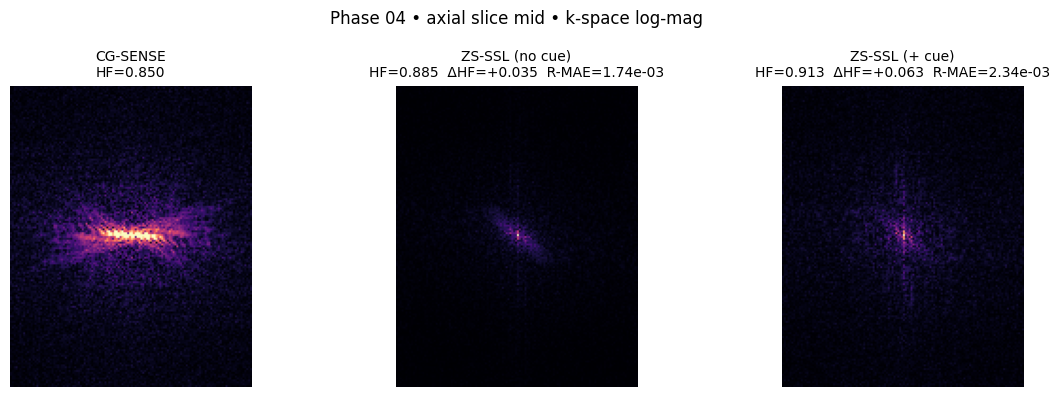

[Phase 04 | axial slice mid]
  CG:      HF=0.850
  No cue:  HF=0.885  ΔHF=+0.035  R-MAE=1.735e-03  | Ω_MSE=—  Ωᶜ_E=—
  + Cue:   HF=0.913  ΔHF=+0.063  R-MAE=2.341e-03  | Ω_MSE=—  Ωᶜ_E=—


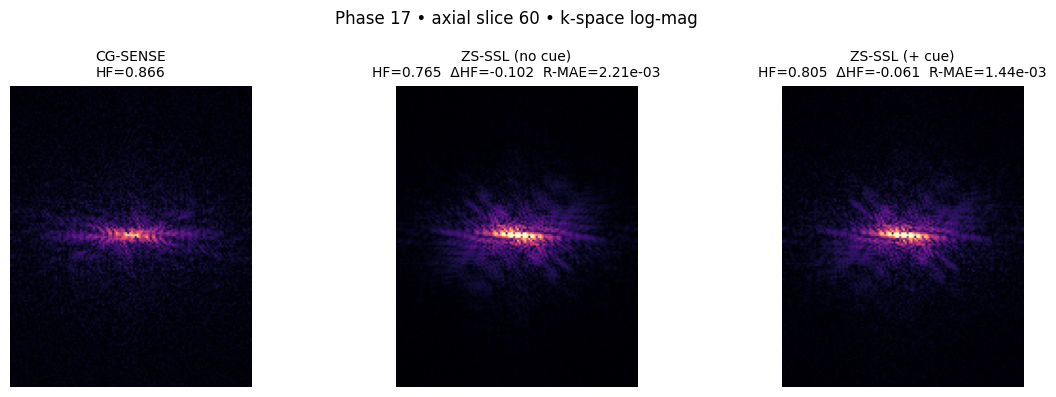

[Phase 17 | axial slice 60]
  CG:      HF=0.866
  No cue:  HF=0.765  ΔHF=-0.102  R-MAE=2.210e-03  | Ω_MSE=—  Ωᶜ_E=—
  + Cue:   HF=0.805  ΔHF=-0.061  R-MAE=1.435e-03  | Ω_MSE=—  Ωᶜ_E=—


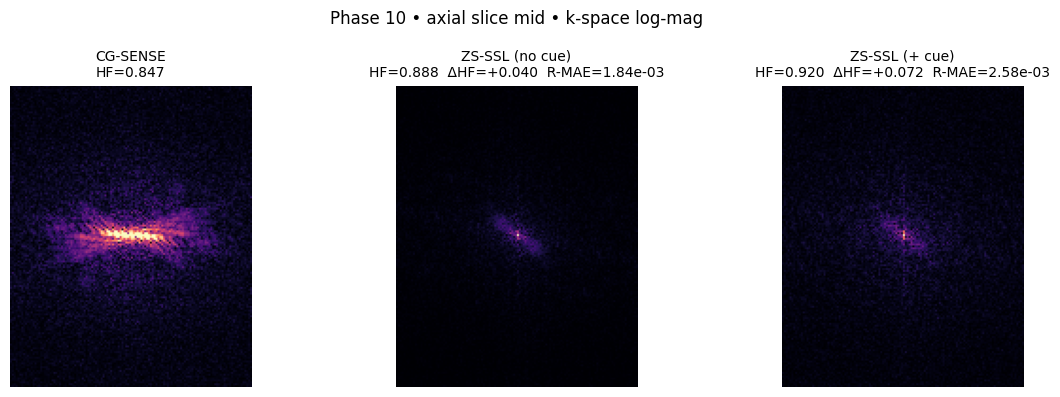

[Phase 10 | axial slice mid]
  CG:      HF=0.847
  No cue:  HF=0.888  ΔHF=+0.040  R-MAE=1.839e-03  | Ω_MSE=—  Ωᶜ_E=—
  + Cue:   HF=0.920  ΔHF=+0.072  R-MAE=2.579e-03  | Ω_MSE=—  Ωᶜ_E=—


In [ ]:
# default: axial mid-slice
show_kspace_slice_triplet(phase=4, view='axial')

# explicit slice/view
show_kspace_slice_triplet(phase=17, view='axial', slice_idx=60)

# linear scale, tighter HF ring
show_kspace_slice_triplet(phase=10, view='axial')

In [127]:
def plot_slice_hist_pair(phase=1, view='axial', slice_idx=None,
                         baseline_dir='cg_baseline_numpy_3d',
                         no_cue_dir='recon/inference_all_phases_1',
                         cue_dir='infer_cued',
                         bins=256, prct=(0.0, 99.5), figsize=(10,4),
                         out_png=None):
    """
    Plot histograms for one slice:
      Left : Baseline (CG) vs ZS-SSL (no cue)
      Right: Baseline (CG) vs ZS-SSL (+ temporal cue)

    Assumes files:
      baseline: {baseline_dir}/phase_XX_cg_sos.npy             (magnitude)
      no-cue  : {no_cue_dir}/phase_XX_recon_sos.npy            (magnitude)
      +cue    : {cue_dir}/phase_XX_recon_img.npy (complex) -> abs used

    Args:
      phase     : 1-based phase index
      view      : 'axial' | 'coronal' | 'sagittal'
      slice_idx : None => mid-slice for that view
      bins      : histogram bins
      prct      : robust range from baseline slice (min,max) percentiles
      out_png   : optional path to save figure
    """
    def _get_slice(vol, view, idx=None):
        X, Y, Z = vol.shape
        if idx is None:
            idx = {'axial': Z//2, 'coronal': Y//2, 'sagittal': X//2}[view]
        if view == 'axial':
            s = vol[:, :, idx]
        elif view == 'coronal':
            s = vol[:, idx, :].T    # (Z,X) -> display (X,Z)-like
        elif view == 'sagittal':
            s = vol[idx, :, :].T    # (Z,Y) -> display (Y,Z)-like
        else:
            raise ValueError("view must be 'axial' | 'coronal' | 'sagittal'")
        return s

    p = int(phase)
    f_cg  = os.path.join(baseline_dir, f"phase_{p:02d}_cg_sos.npy")
    f_nc  = os.path.join(no_cue_dir,   f"phase_{p:02d}_recon_sos.npy")
    f_cue = os.path.join(cue_dir,      f"phase_{p:02d}_recon_img.npy")  # complex

    # Load volumes
    cg_vol  = np.load(f_cg)                           # (X,Y,Z) magnitude
    nc_vol  = np.load(f_nc)                           # (X,Y,Z) magnitude
    cue_vol = np.load(f_cue)                          # (X,Y,Z) complex -> abs
    if np.iscomplexobj(cue_vol):
        cue_vol = np.abs(cue_vol).astype(np.float32)
    else:
        cue_vol = cue_vol.astype(np.float32)

    # Extract the slice
    cg_s  = _get_slice(cg_vol,  view, slice_idx).astype(np.float32)
    nc_s  = _get_slice(nc_vol,  view, slice_idx).astype(np.float32)
    cue_s = _get_slice(cue_vol, view, slice_idx).astype(np.float32)

    # Robust range from baseline slice
    vmin = np.percentile(cg_s, prct[0])
    vmax = np.percentile(cg_s, prct[1])
    lo, hi = float(vmin), float(max(vmax, vmin + 1e-12))

    # Clip and flatten
    def _prep(x): 
        return np.clip(x, lo, hi).ravel()
    cg_flat, nc_flat, cue_flat = _prep(cg_s), _prep(nc_s), _prep(cue_s)

    # Common bins/range (from baseline)
    hist_range = (lo, hi)

    fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # Left: baseline vs no-cue
    ax[0].hist(cg_flat,  bins=bins, range=hist_range, density=True,
               histtype='step', color='k',   label='Baseline (CG)')
    ax[0].hist(nc_flat,  bins=bins, range=hist_range, density=True,
               histtype='step', color='tab:blue', label='ZS-SSL (no cue)')
    ax[0].set_title(f"Phase {p:02d} • {view} • slice {slice_idx if slice_idx is not None else 'mid'}\nBaseline vs ZS-SSL(No cue)")
    ax[0].set_xlabel("Magnitude")
    ax[0].set_ylabel("Density")
    ax[0].legend(loc='upper right', fontsize=9)

    # Right: baseline vs +cue
    ax[1].hist(cg_flat,   bins=bins, range=hist_range, density=True,
               histtype='step', color='k',   label='Baseline (CG)')
    ax[1].hist(cue_flat,  bins=bins, range=hist_range, density=True,
               histtype='step', color='tab:orange', label='ZS-SSL (+ cue)')
    ax[1].set_title(f"Phase {p:02d} • {view} • slice {slice_idx if slice_idx is not None else 'mid'}\nBaseline vs ZS-SSL(with time Cue)")
    ax[1].set_xlabel("Magnitude")
    ax[1].legend(loc='upper right', fontsize=9)

    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=300, bbox_inches='tight')
        print(f"Saved → {out_png}")
    plt.show()

Saved → results/phase04_axial_hist.png


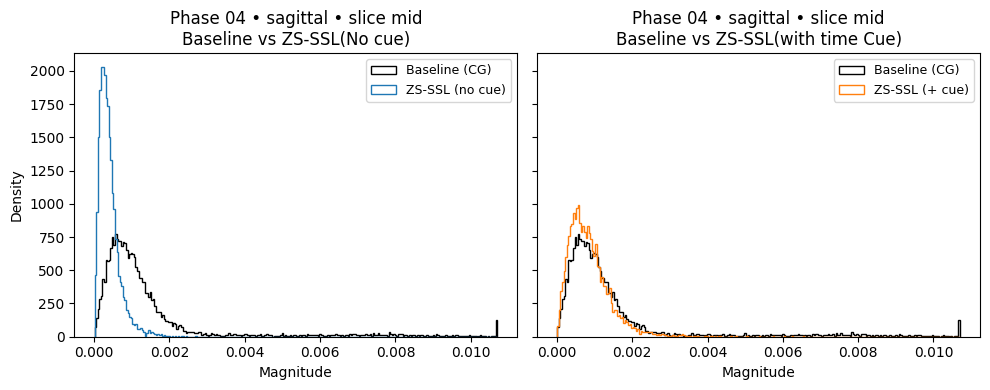

Saved → results/phase17_sagittal_hist.png


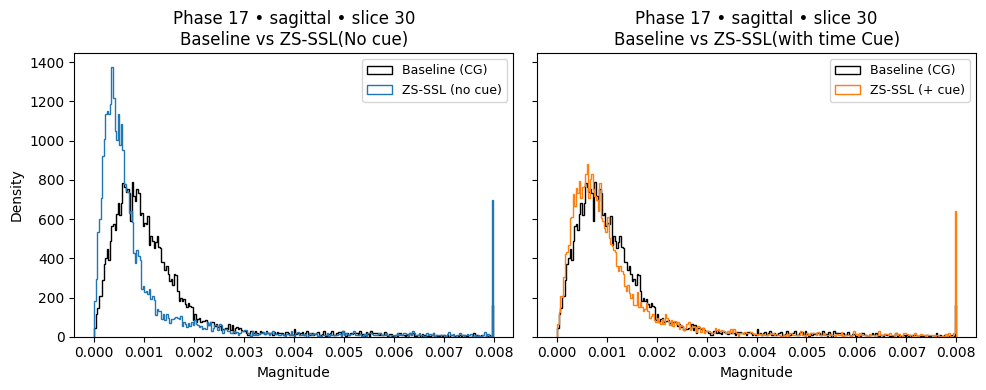

In [129]:
# Phase 4, axial mid-slice
plot_slice_hist_pair(phase=4, view='sagittal', out_png='results/phase04_axial_hist.png')

# Phase 17, sagittal slice 30, save figure
plot_slice_hist_pair(phase=17, view='sagittal', slice_idx=30,
                     out_png='results/phase17_sagittal_hist.png')